## 1. Initalization

### 1.1 Load dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("UltimateClassicRock.csv")
df['Decade'] = (df['Year'] // 10) * 10
df['Decade'] = df['Decade'].astype(str) + 's'
order = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
df['Decade'] = pd.Categorical(df['Decade'], categories=order, ordered=True)


def convert_duration(duration):
    minutes, seconds = map(int, duration.split(':'))
    return minutes * 60 + seconds

df['Duration'] = df['Duration'].apply(convert_duration)

A = df.drop(['Track', 'Artist', 'Album', 'Year', 'Energy', 'Decade'], axis=1)
b = df['Energy']
A.head()

,Duration,Time_Signature,Danceability,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Popularity
0,193,4,0.521,0,-13.866,1,0.0278,0.6920,0.000003,0.1080,0.789,83.412,16
1,283,4,0.535,2,-12.287,1,0.0428,0.0100,0.023000,0.0495,0.445,160.361,10
2,313,4,0.563,2,-10.781,1,0.0263,0.0357,0.001850,0.1400,0.564,106.739,13
3,249,4,0.638,11,-10.206,0,0.0310,0.1610,0.000034,0.0908,0.936,124.962,10
4,357,4,0.388,2,-9.984,1,0.0360,0.0130,0.042200,0.1150,0.769,126.769,11


### 1.2 Prepare the dataset & model

In [3]:
from sklearn.model_selection import train_test_split
from utils.linear_regressionGD import LinearRegressionGD

In [4]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, shuffle=True, random_state=42)

model = LinearRegressionGD(learning_rate=0.001, iterations=100, batch_size=32)
model.fit(A_train, b_train, A_test, b_test)
predictions = model.predict(A_test)

## 2. Cross validation

In [5]:
#evaluate
from sklearn.metrics import mean_squared_error
print("MSE on test set:", mean_squared_error(b_test, predictions))

#cross-validation on the full dataset
result = model.cross_validate(A, b, k=3)
print(f"Average final cost across the 3 folds {result}")

MSE on test set: 0.012390933144272906

Fold 1 validation cost (MSE): 0.006208

Fold 2 validation cost (MSE): 0.006388

Fold 3 validation cost (MSE): 0.005901
Average final cost across the 3 folds 0.006165403369296638


## 3. Convergence plots & error analysis

### 3.1 Convergence of cost function graph before new attributes

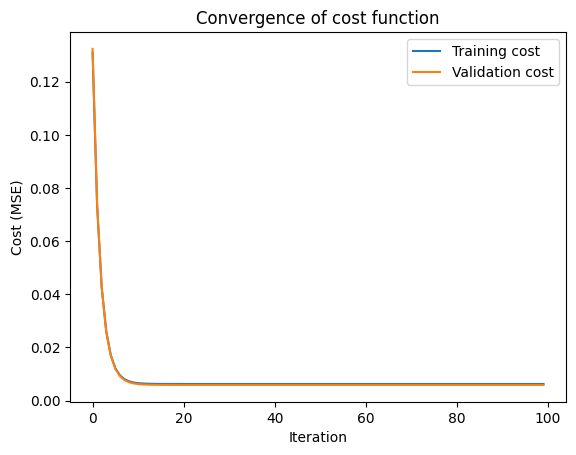

In [6]:
import matplotlib.pyplot as plt

plt.plot(model.cost_history_train, label='Training cost')
if model.cost_history_val:
    plt.plot(model.cost_history_val, label='Validation cost')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Convergence of cost function')
plt.legend()
plt.show()

### 3.2 Convergence of cost function graph after new attributes

In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
A_poly = poly.fit_transform(A)

A_train_poly, A_test_poly, b_train, b_test = train_test_split(A_poly, b, test_size=0.2, random_state=42)

model = LinearRegressionGD(learning_rate=0.001, iterations=100, batch_size=32)
model.fit(A_train_poly, b_train, A_test_poly, b_test)

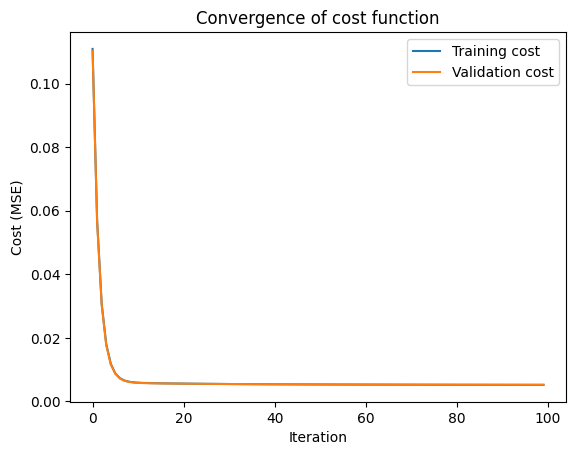

In [8]:
plt.plot(model.cost_history_train, label='Training cost')
if model.cost_history_val:
    plt.plot(model.cost_history_val, label='Validation cost')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Convergence of cost function')
plt.legend()
plt.show()

### 3.3 Convergence of cost function graph after reduction of attributes

In [9]:
A_np = A.to_numpy()
A_subset = A_np[:, :4]

A_red_train, A_red_test, b_train, b_test = train_test_split(A_subset, b, test_size=0.2, shuffle=True, random_state=42)

model = LinearRegressionGD(learning_rate=0.001, iterations=100, batch_size=32)
model.fit(A_red_train, b_train, A_red_test, b_test)
predictions = model.predict(A_red_test)

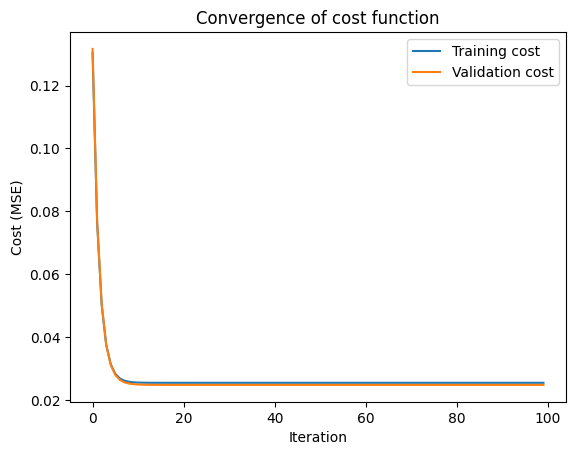

In [10]:
plt.plot(model.cost_history_train, label='Training cost')
if model.cost_history_val:
    plt.plot(model.cost_history_val, label='Validation cost')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Convergence of cost function')
plt.legend()
plt.show()

## 4. Regularization L1, L2 and None

In [11]:
model_no_reg = LinearRegressionGD(learning_rate=0.001, iterations=100, regularization=None)
model_no_reg.fit(A_train, b_train)
print("Weights without regularization:", model_no_reg.theta)

model_l2 = LinearRegressionGD(learning_rate=0.001, iterations=100, regularization='l2', lr_lambda=0.1)
model_l2.fit(A_train, b_train)
print("Weights with L2 regularization:", model_l2.theta)

model_l1 = LinearRegressionGD(learning_rate=0.001, iterations=100, regularization='l1', lr_lambda=0.1)
model_l1.fit(A_train, b_train)
print("Weights with L1 regularization:", model_l1.theta)


Weights without regularization: [ 0.65556319  0.00450301  0.01126858 -0.01819925  0.00134588  0.12969323
 -0.00366691  0.0340379  -0.07413847  0.01699496  0.01858378  0.05045138
  0.00586101 -0.00132242]
Weights with L2 regularization: [ 0.65556288  0.00451088  0.01130538 -0.01789606  0.00134418  0.12888019
 -0.00366184  0.03384759 -0.07411433  0.01674826  0.01861835  0.05004691
  0.00602724 -0.00132229]
Weights with L1 regularization: [ 6.55594423e-01  7.61161362e-05  5.38046337e-03 -8.43791141e-03
  6.83617725e-05  1.25474197e-01 -3.57698235e-04  2.94860850e-02
 -7.40974164e-02  1.08057397e-02  1.50808982e-02  3.88286576e-02
  3.08704494e-03 -5.59517226e-05]


In [12]:
print("Mean weight values:")
print(f"No regularization mean: {np.mean(np.abs(model_no_reg.theta)):.6f}")
print(f"L2 regularization mean: {np.mean(np.abs(model_l2.theta)):.6f}")
print(f"L1 regularization mean: {np.mean(np.abs(model_l1.theta)):.6f}")

Mean weight values:
No regularization mean: 0.073259
L2 regularization mean: 0.073135
L1 regularization mean: 0.069059


### Summary

- **No regularization**: Weights have the highest average magnitude.
- **L2 regularization (Ridge)**: Slightly reduces the average weight size by shrinking weights, but most remain non-zero.
- **L1 regularization (Lasso)**: Reduces the average weight more and pushes some weights close to zero.
- Both methods help reduce **overfitting** by controlling the size of weights.

## 5. Handling imbalanced data

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [14]:
X = df.drop(['Track', 'Artist', 'Album', 'Year', 'Decade', 'Mode'], axis=1)
y = df['Mode']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.1 Oversampling

In [17]:
smote = SMOTE(random_state=12)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Original class distribution:\n", y.value_counts())
print("After SMOTE oversampling:\n", pd.Series(y_train_smote).value_counts())

Original class distribution:
 Mode
1    10527
0     3891
Name: count, dtype: int64
After SMOTE oversampling:
 Mode
1    8421
0    8421
Name: count, dtype: int64


### 5.2 Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

print("Original class distribution:\n", y_train_class.value_counts())
print("After RUS undersampling:\n", pd.Series(y_train_rus).value_counts())

In [ ]:
def train_and_eval(X_tr, y_tr, X_te, y_te, desc):
    model = LinearRegressionGD()
    model.fit(X_tr, y_tr)
    y_pred_cont = model.predict(X_te)
    y_pred = (y_pred_cont >= 0.5).astype(int)
    
    print(f"\nEvaluation on {desc} dataset:")
    print(classification_report(y_te, y_pred))


train_and_eval(X_train_scaled, y_train, X_test_scaled, y_test, "original")
train_and_eval(X_train_smote, y_train_smote, X_test_scaled, y_test, "SMOTE oversampled")
train_and_eval(X_train_rus, y_train_rus, X_test_scaled, y_test, "undersampled")

- **Original dataset:**  
  - High recall for major class (1) - biased towards major
  - Low recall for minor class (0) - poor detection of minor

- **SMOTE oversampled:**  
  - Better recall for minor class (0) - improved detection  
  - Recall for major class drops  
  - Overall accuracy decreases  

- **Undersample dataset:**  
  - Balanced recall between classes - better minor detection
  - Accuracy lower than original, but better than SMOTE  
  - Precision and F1-scores show improvement in minor class handling  


## 6. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled


### 6.1 Decision tree

In [ ]:
dt = DecisionTreeClassifier(random_state=67)

In [ ]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],           # max depth of the tree
    'min_samples_split': [2, 5, 10],          # min samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]             # min samples required to be at a leaf node
}

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Best Decision Tree parameters:", grid_dt.best_params_)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
print("\nDecision Tree classification report:")
print(classification_report(y_test, y_pred_dt))


### 6.2 KNeighbors Classifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train_scaled, y_train)

print("Best KNN parameters:", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
print("\nKNN classification report:")
print(classification_report(y_test, y_pred_knn))

Hyperparameter tuning is hard because:

- There are many possible parameter combinations to try.
- Training and testing each takes a lot of time and resources.
- Small changes in parameters can cause big differences in results.
- Some parameters affect each other, making the search complex.